[1,   200] loss: 0.713
[2,   200] loss: 0.562
[3,   200] loss: 0.502
[4,   200] loss: 0.445
[5,   200] loss: 0.396
[6,   200] loss: 0.364
[7,   200] loss: 0.342
[8,   200] loss: 0.316
[9,   200] loss: 0.303
[10,   200] loss: 0.283
[11,   200] loss: 0.272
[12,   200] loss: 0.259
[13,   200] loss: 0.250
[14,   200] loss: 0.241
[15,   200] loss: 0.234
[16,   200] loss: 0.229
[17,   200] loss: 0.221
[18,   200] loss: 0.222
[19,   200] loss: 0.214
[20,   200] loss: 0.208
[21,   200] loss: 0.207
[22,   200] loss: 0.206
[23,   200] loss: 0.200
[24,   200] loss: 0.192
[25,   200] loss: 0.194
[26,   200] loss: 0.193
[27,   200] loss: 0.191
[28,   200] loss: 0.190
[29,   200] loss: 0.189
[30,   200] loss: 0.185
Finished Training


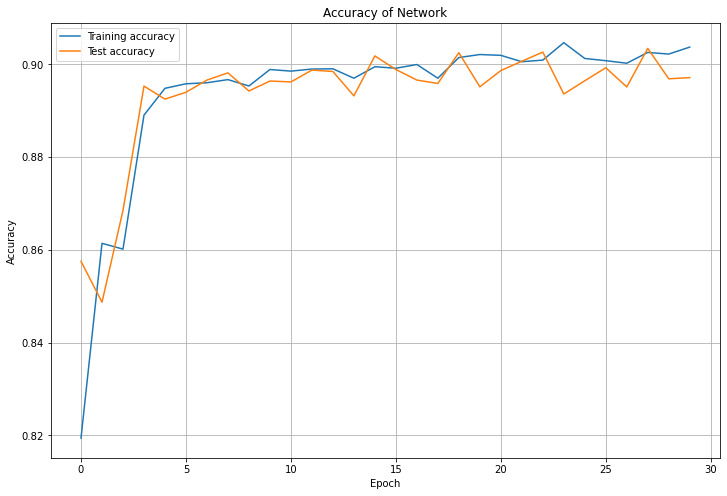

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0, './Onedrive/Project-T2/PointNetJJ')
from spheres_JJ import sphere_generator
from spheres_JJ import ellipsoid_generator
from spheres_JJ import return_rod
from spheres_JJ import return_square

from rotation import rotate_point_cloud
from rotation import LOP




class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(1024)
        self.bn5 = nn.BatchNorm1d(512)
        self.bn6 = nn.BatchNorm1d(256)
        self.bn7 = nn.BatchNorm1d(k)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn5(self.fc1(x)))
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.fc3(x)

        x = F.relu(self.bn7(self.dropout(x)))
        return F.log_softmax(x, dim=1)
   
nclouds = 10000
npoints = 60

# The point clouds

spheres = torch.from_numpy(sphere_generator(0.2, nclouds, npoints))
ellipsoids = torch.from_numpy(ellipsoid_generator(0.2,1 ,1 ,np.random.uniform(2,5), nclouds, npoints))
rods = torch.from_numpy(return_rod(0.2,1,np.random.uniform(2,5), nclouds, npoints))
squares = torch.from_numpy(return_square(0.2,nclouds, npoints))

trainset = torch.cat((spheres, ellipsoids, rods, squares))

# Labels
zeros = torch.zeros(nclouds, dtype=torch.long)
ones = torch.ones(nclouds, dtype=torch.long)
twos = torch.ones(nclouds, dtype=torch.long) * 2
threes = torch.ones(nclouds, dtype=torch.long) * 3
labels = torch.cat((zeros, ones, twos, threes))
labels_train = labels

dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                          shuffle=True, num_workers=2,drop_last = True)

#####################################################
# Testing


ncloudstest = 10000
npointstest = 60

# The point clouds
spherestest = torch.from_numpy(sphere_generator(0.2, ncloudstest, npointstest))
ellipsoidstest = torch.from_numpy(ellipsoid_generator(0.2, 1, 1, np.random.uniform(2,5), ncloudstest, npointstest))
rodtest = torch.from_numpy(return_rod(0.2, 1, np.random.uniform(2,5), ncloudstest, npointstest))
squarestest = torch.from_numpy(return_square(0.2, ncloudstest, npointstest))

testset = torch.cat((spherestest, ellipsoidstest, rodtest, squarestest))
testset_keep = testset

# Labels
testzeros = torch.zeros(ncloudstest, dtype=torch.long)
testones = torch.ones(ncloudstest, dtype=torch.long)
testtwos = torch.ones(ncloudstest, dtype=torch.long) * 2
testthrees = torch.ones(ncloudstest, dtype=torch.long) * 3

testlabels = torch.cat((testzeros, testones, testtwos, testthrees))
labels_test = testlabels

testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=True, num_workers=2, drop_last = True)

#############################################################3

net = PointNetCls(k=4)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

nepochs = 30
train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    epoch_train_acc = 0.0
    running_loss = 0.0
    epoch_train_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(rotate_point_cloud(inputs))
        outputs_train = outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        _, train_predicted = torch.max(outputs_train.data, 1)
        epoch_train_acc += (train_predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        epoch_train_loss += loss.item()
        counter += 1
        #print(i)
        if i % 200 == 199:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    
    epoch_test_acc = 0.0
    counter2 = 0.0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        _, test_predicted = torch.max(outputs.data, 1)
        epoch_test_acc += (test_predicted == labels).sum().item()
        counter2 += 1

    train_acc[epoch] = epoch_train_acc/counter/128
    test_acc[epoch] = epoch_test_acc /counter2/128
    train_loss[epoch] = criterion(net(rotate_point_cloud(trainset)), labels_train).item()
    test_loss[epoch] = criterion(net(rotate_point_cloud(testset_keep)), labels_test).item()
    epoch_train_loss = 0.0    

print('Finished Training')

plt.figure(figsize=(12,8))
plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Test accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy of Network')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

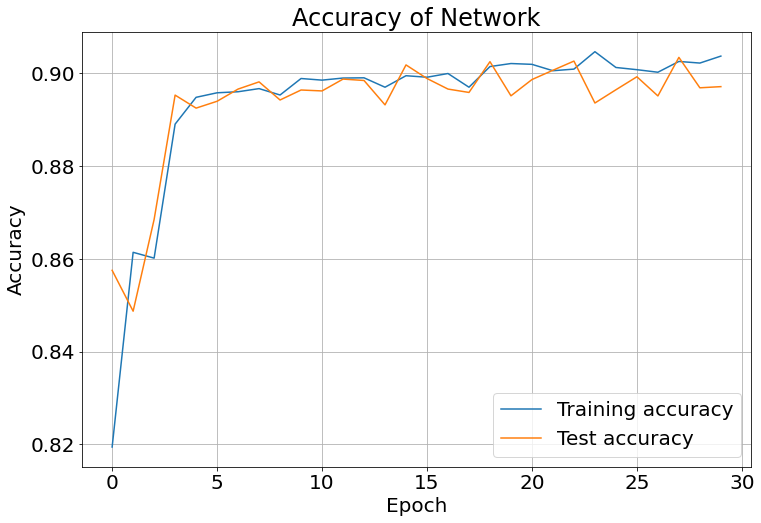

Accuracy of the network on the test point clouds: 89 %


In [3]:
x = np.arange(nepochs)
plt.figure(figsize=(12,8))
font = {'size'   : 20}
plt.rc('font', **font)
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, test_acc, label='Test accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy of Network')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('Accuracy3DJJlr5.jpeg', bbox_inches ='tight')
plt.show()

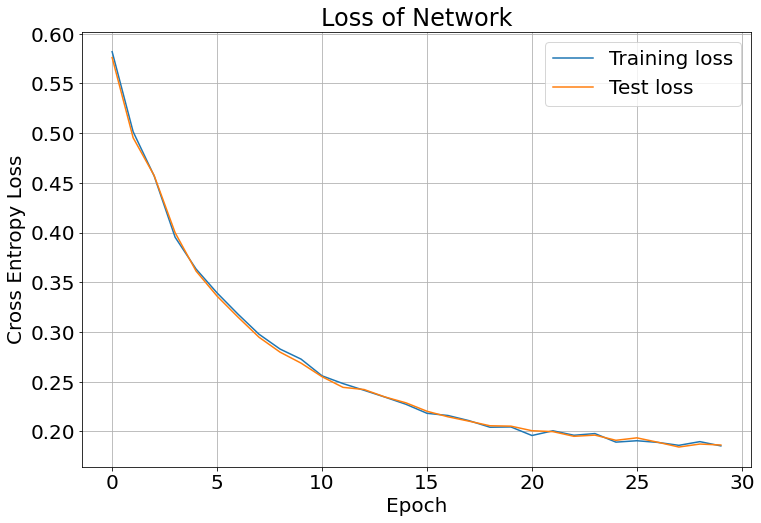

In [4]:
x = np.arange(nepochs)
plt.figure(figsize=(12,8))
plt.plot(x, train_loss, label='Training loss')
plt.plot(x, test_loss, label='Test loss')
plt.rc('font', **font)
plt.legend()
plt.grid()
plt.title('Loss of Network')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.savefig('Loss1Dlr5.jpeg', bbox_inches ='tight')
plt.show()

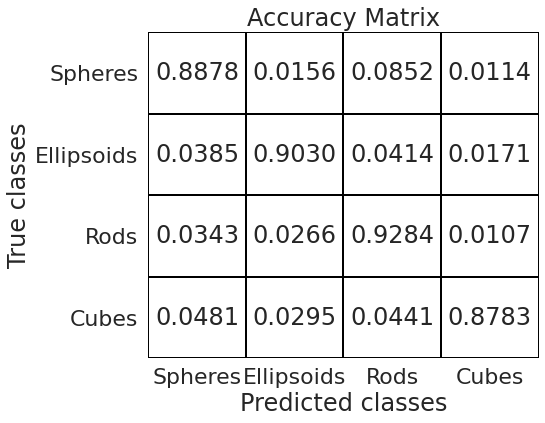

In [6]:
import sklearn
import seaborn as sn
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
#net.eval()
#net.train()
# Confusion matrix
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# classes
classes = ('Spheres', 'Ellipsoids', 'Rods', 'Cubes')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#cf_matrix = cf_matrix/100
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *4, index = [i for i in classes],
                     columns = [i for i in classes])

# plot
sn.set(font_scale=2)
plt.figure(figsize = (7,6))
sn.heatmap(df_cm, annot=True,cbar=False,linewidths=1,linecolor='black', cmap=ListedColormap(['white']), 
                      fmt = ".4f")

plt.ylabel('True classes')
plt.xlabel('Predicted classes') 

#plt.xlabel('True classes')
#plt.ylabel('Predicted classes') 
plt.title('Accuracy Matrix')
plt.savefig('Confusion_matrix.jpeg', bbox_inches ='tight')
plt.show()